In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import operator
from datetime import datetime
import seaborn as sns
import numpy as np
import xgboost as xgb
import plotly as py
import plotly.graph_objs as go
sns.set(font_scale=2)

py.offline.init_notebook_mode(connected=True)
%matplotlib inline


In [52]:
#reading the data
dateparse=lambda x:pd.datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
data_file1=pd.read_csv("../dataset/file1.csv",sep="|",parse_dates=["Date"],date_parser=dateparse)
data_file1.head()

,Lat Code,Long Code,SEId,RouteId,StoreId,Date,SalesVolumeKG,SalesVolumeLt,SalesGrossValue,SalesTaxValue,SalesNetValue,TotalLines,FlgPlanned,FlgCovered,FlgProductive,PlannedCalls,ActualCalls,ProductiveCalls,FlgNewStore
0,17.701415,74.161672,0,567,40827,2016-06-11,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,1
1,18.543995,73.782319,216,1558,51711,2016-06-06,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,0
2,18.452870,73.882522,307,1599,52251,2016-06-06,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,0
3,22.996360,72.663287,94,753,37206,2016-06-07,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,0
4,15.390768,73.995228,67,526,41378,2016-06-06,0.0,3.0,1146.383,57.32,1203.703,2,0,1,1,0,1,1,0


# Data cleaning

In [53]:

data_file1.drop(["Lat Code","Long Code"],inplace=True,axis=1)

In [54]:
#analysis of null value
data_file1.isnull().sum()/data_file1.isnull().count()

SEId               0.0
RouteId            0.0
StoreId            0.0
Date               0.0
SalesVolumeKG      0.0
SalesVolumeLt      0.0
SalesGrossValue    0.0
SalesTaxValue      0.0
SalesNetValue      0.0
TotalLines         0.0
FlgPlanned         0.0
FlgCovered         0.0
FlgProductive      0.0
PlannedCalls       0.0
ActualCalls        0.0
ProductiveCalls    0.0
FlgNewStore        0.0
dtype: float64

In [55]:
#sneak peak into data
data_file1.head()

,SEId,RouteId,StoreId,Date,SalesVolumeKG,SalesVolumeLt,SalesGrossValue,SalesTaxValue,SalesNetValue,TotalLines,FlgPlanned,FlgCovered,FlgProductive,PlannedCalls,ActualCalls,ProductiveCalls,FlgNewStore
0,0,567,40827,2016-06-11,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,1
1,216,1558,51711,2016-06-06,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,0
2,307,1599,52251,2016-06-06,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,0
3,94,753,37206,2016-06-07,0.0,0.0,0.000,0.00,0.000,0,0,1,0,0,1,0,0
4,67,526,41378,2016-06-06,0.0,3.0,1146.383,57.32,1203.703,2,0,1,1,0,1,1,0


In [56]:
#Adding day,month and year columns
data_file1["Year"]=data_file1["Date"].dt.year
data_file1['Year'] = data_file1['Year'].astype(float)
data_file1["Month"]=data_file1["Date"].dt.month
data_file1['Month'] = data_file1['Month'].astype(float)
data_file1["Day"]=data_file1["Date"].dt.day
data_file1['Day'] = data_file1['Day'].astype(float)
data_file1.sample()

,SEId,RouteId,StoreId,Date,SalesVolumeKG,SalesVolumeLt,SalesGrossValue,SalesTaxValue,SalesNetValue,TotalLines,FlgPlanned,FlgCovered,FlgProductive,PlannedCalls,ActualCalls,ProductiveCalls,FlgNewStore,Year,Month,Day
696375,0,1255,57400,2016-12-16,0.0,1.2,535.438,32.13,567.568,1,1,1,1,1,1,1,0,2016.0,12.0,16.0


In [57]:
#Data analysis
number_of_distinct_stores=len(list(data_file1.StoreId.unique()))
number_of_distinct_days=len(list(data_file1.Date.unique()))
number_of_distinct_routes=len(list(data_file1.RouteId.unique()))
number_of_distinct_reps=len(list(data_file1.SEId.unique()))
print("The data is a record of {} stores on {} routes covered by {} reps over {} days".format(number_of_distinct_stores,number_of_distinct_routes,number_of_distinct_reps,number_of_distinct_days))

The data is a record of 46455 stores on 1110 routes covered by 162 reps over 602 days


In [58]:
data_file1['quarters'] = data_file1.Date.dt.quarter


In [59]:
#Quarterising data
twenty_sixteen_data=data_file1.loc[data_file1["Year"]==2016]
twenty_seventeen_data=data_file1.loc[data_file1["Year"]==2017]
q3_2016=twenty_sixteen_data.loc[twenty_sixteen_data["quarters"]==3]
q4_2016=twenty_sixteen_data.loc[twenty_sixteen_data["quarters"]==4]
q1_2017=twenty_seventeen_data.loc[twenty_seventeen_data["quarters"]==1]
q2_2017=twenty_seventeen_data.loc[twenty_seventeen_data["quarters"]==2]
q3_2017=twenty_seventeen_data.loc[twenty_seventeen_data["quarters"]==3]
q4_2017=twenty_seventeen_data.loc[twenty_seventeen_data["quarters"]==4]


# Descriptive Analysis

In [60]:
#some functions for descriptive analysis

    
    
def group_analysis(data_file,column_name,reference_column,reference_value):
    productive_dict=data_file.loc[data_file[reference_column]==reference_value].groupby(data_file[column_name]).groups
    productive_dict={key:len(value) for key,value in productive_dict.items()}
    productive_dict = sorted(productive_dict.items(), key=operator.itemgetter(1))

    return productive_dict

def group_to_arrays(group):
    array_x=[]
    array_y=[]
    for elements in group:
        x,y=elements
        array_x.append(x)
        array_y.append(y)
    return array_x,array_y

def render_grouped_productive(data_file,column_name,reference_column,reference_value,axis_label_x,axis_label_y):
    productive=group_analysis(data_file,column_name,reference_column,reference_value)
    least_10_productive=productive[:10]
    most_10_productive=productive[-10:]
    array_least_x,array_least_y=group_to_arrays(least_10_productive)
    dataframe_least={axis_label_x:array_least_x,axis_label_y:array_least_y}
    array_most_x,array_most_y=group_to_arrays(most_10_productive)
    dataframe_most={axis_label_x:array_most_x,axis_label_y:array_most_y}
    fig, cnt =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax = sns.barplot(x=axis_label_x, y=axis_label_y, data=dataframe_least, palette="Blues_d",ax=cnt[0])
    ax.set(xlabel=axis_label_x, ylabel=axis_label_y,title="Least Productive calls "+column_name)
    ax1 = sns.barplot(x=axis_label_x, y=axis_label_y, data=dataframe_most, palette="Blues_d",ax=cnt[1])
    ax1.set(xlabel=axis_label_x, ylabel=axis_label_y,title="Most Productive calls "+column_name)
    
    fig.show()
    
    #plot_bar_plotly("Least Productive calls "+column_name,axis_label_x,axis_label_y,array_least_x,array_least_y)
    #plot_bar_plotly("Most Productive calls "+column_name,axis_label_x,axis_label_y,array_most_x,array_most_y)

    



def render_grouped_unproductive(data_file,column_name,reference_column,reference_value,axis_label_x,axis_label_y):
    productive=group_analysis(data_file,column_name,reference_column,reference_value)
    least_10_unproductive=productive[:10]
    most_10_unproductive=productive[-10:]
    array_least_x,array_least_y=group_to_arrays(least_10_unproductive)
    dataframe_least={axis_label_x:array_least_x,axis_label_y:array_least_y}
    array_most_x,array_most_y=group_to_arrays(most_10_unproductive)
    dataframe_most={axis_label_x:array_most_x,axis_label_y:array_most_y}
    fig, cnt =plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax = sns.barplot(x=axis_label_x, y=axis_label_y, data=dataframe_least, palette="Blues_d",ax=cnt[0])
    ax.set(xlabel=axis_label_x, ylabel=axis_label_y,title="Least UnProductive calls "+column_name)
    ax1 = sns.barplot(x=axis_label_x, y=axis_label_y, data=dataframe_most, palette="Blues_d",ax=cnt[1])
    ax1.set(xlabel=axis_label_x, ylabel=axis_label_y,title="Most UnProductive calls "+column_name)
    
    fig.show()
    
    #plot_bar_plotly("Least UnProductive calls "+column_name,axis_label_x,axis_label_y,array_least_x,array_least_y)
    #plot_bar_plotly("Most UnProductive calls "+column_name,axis_label_x,axis_label_y,array_most_x,array_most_y)


## Analysis for Q3 2017 and Q4 2017

## Productivity vs SEId

#### Q3 2017

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



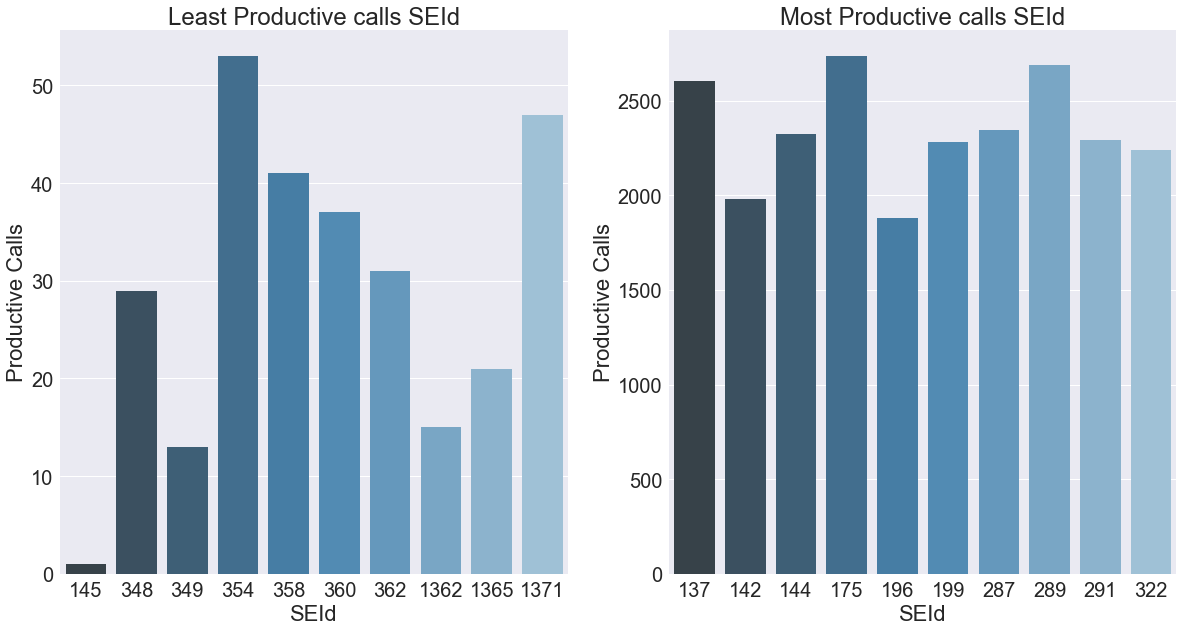

In [61]:
render_grouped_productive(q3_2017,"SEId","ProductiveCalls",1,'SEId',"Productive Calls")

#SEId with least 10 productive calls                          #SEId with most 10 productive calls

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



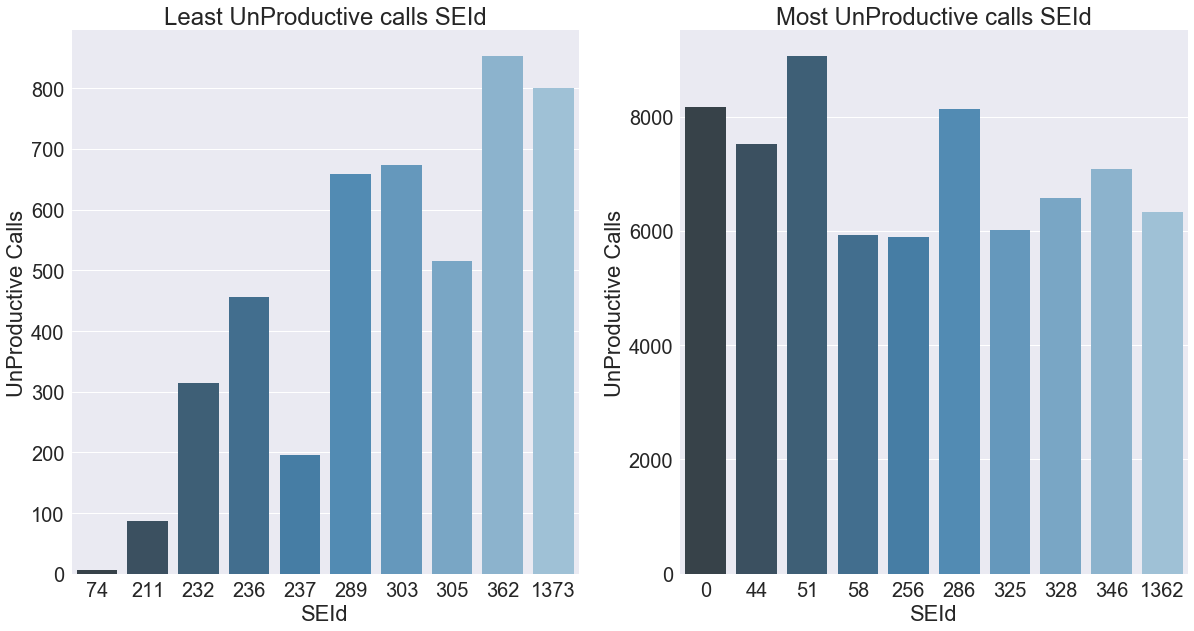

In [62]:
render_grouped_unproductive(q3_2017,"SEId","ProductiveCalls",0,'SEId',"UnProductive Calls")

#SEId with least 10 unproductive calls                          #SEId with most 10 unproductive calls

#### Q4 2017

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



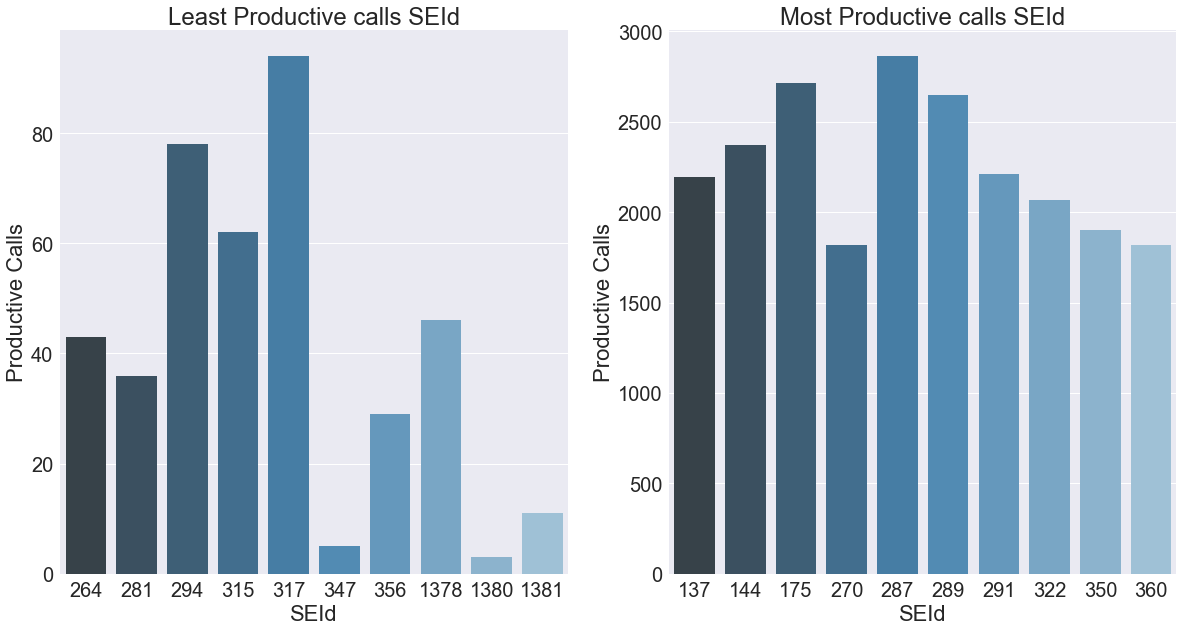

In [63]:
render_grouped_productive(q4_2017,"SEId","ProductiveCalls",1,'SEId',"Productive Calls")


/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



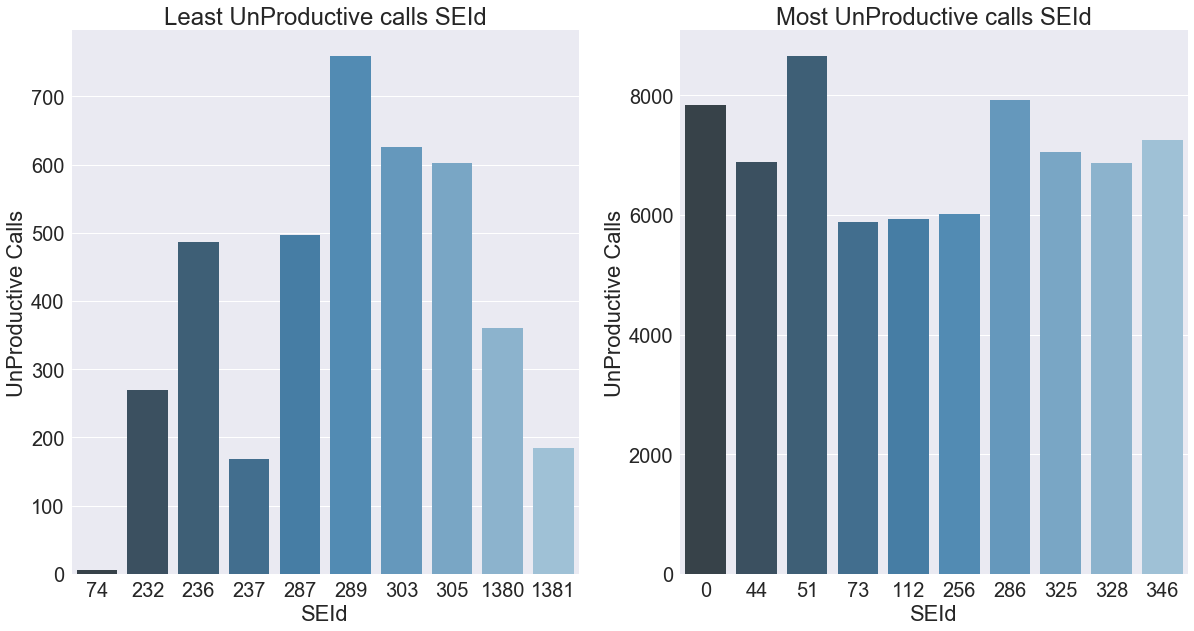

In [64]:
render_grouped_unproductive(q4_2017,"SEId","ProductiveCalls",0,'SEId',"UnProductive Calls")


## Productivity vs RouteId

#### Q3 2017

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



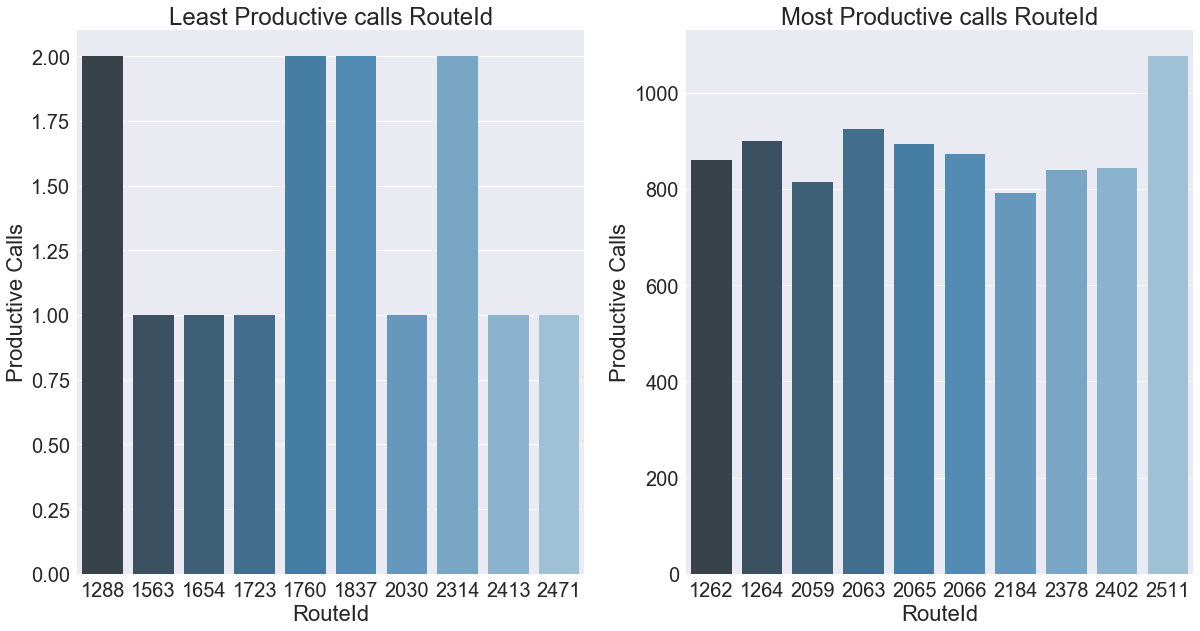

In [65]:
render_grouped_productive(q3_2017,"RouteId","ProductiveCalls",1,'RouteId',"Productive Calls")

#RouteId with least 10 productive calls                          #RouteId with most 10 productive calls

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



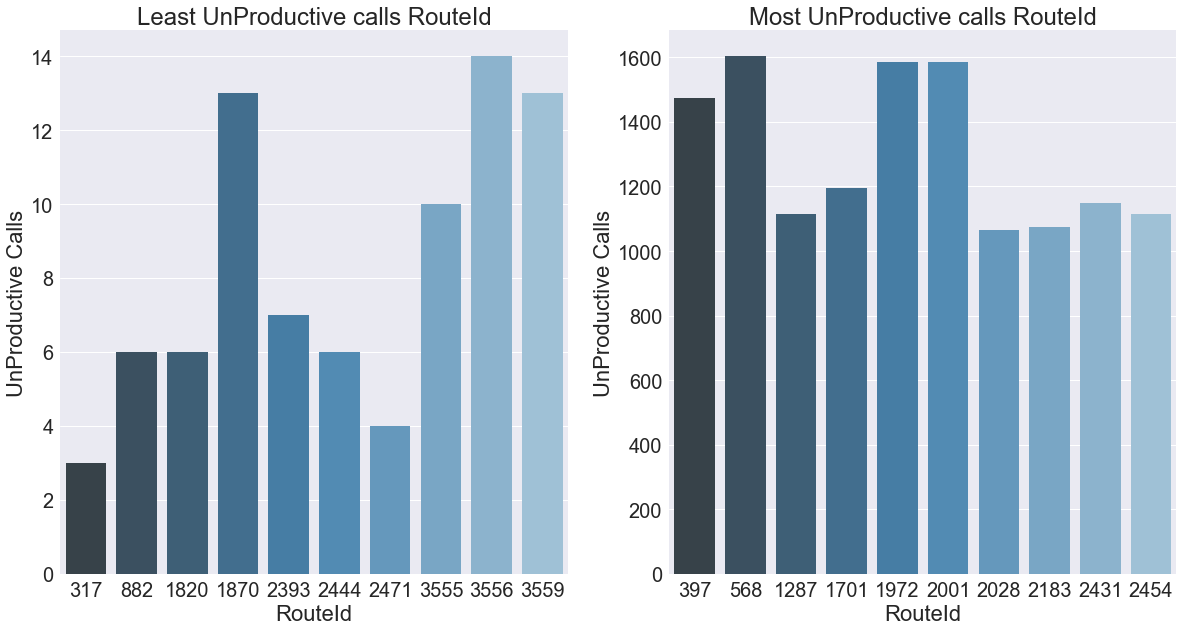

In [66]:
render_grouped_unproductive(q3_2017,"RouteId","ProductiveCalls",0,'RouteId',"UnProductive Calls")

#RouteId with least 10 unproductive calls                          #RouteId with most 10 unproductive calls

#### Q4 2017

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



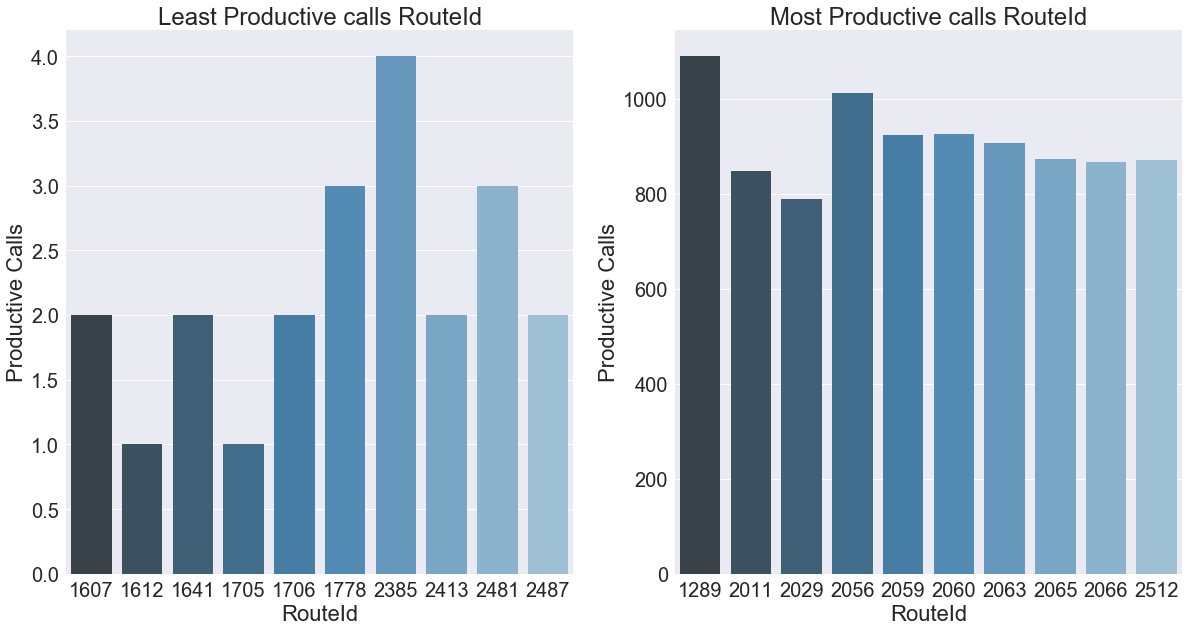

In [67]:
render_grouped_productive(q4_2017,"RouteId","ProductiveCalls",1,'RouteId',"Productive Calls")


/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



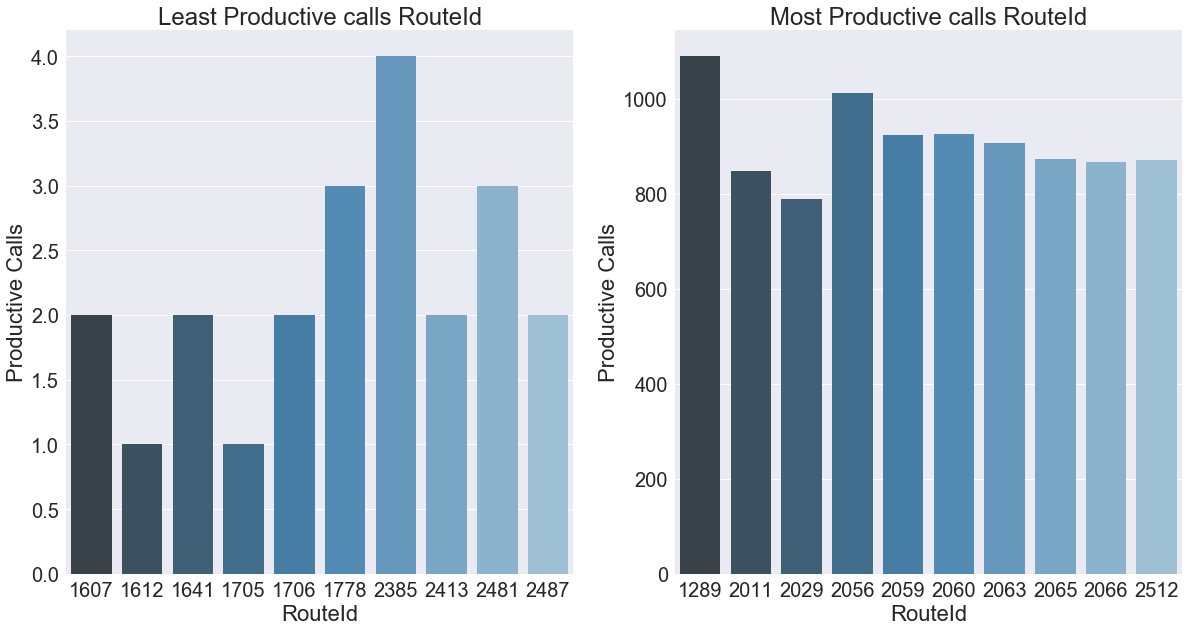

In [68]:
render_grouped_productive(q4_2017,"RouteId","ProductiveCalls",1,'RouteId',"Productive Calls")


## Productivity vs StoreId

#### Q3 2017

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



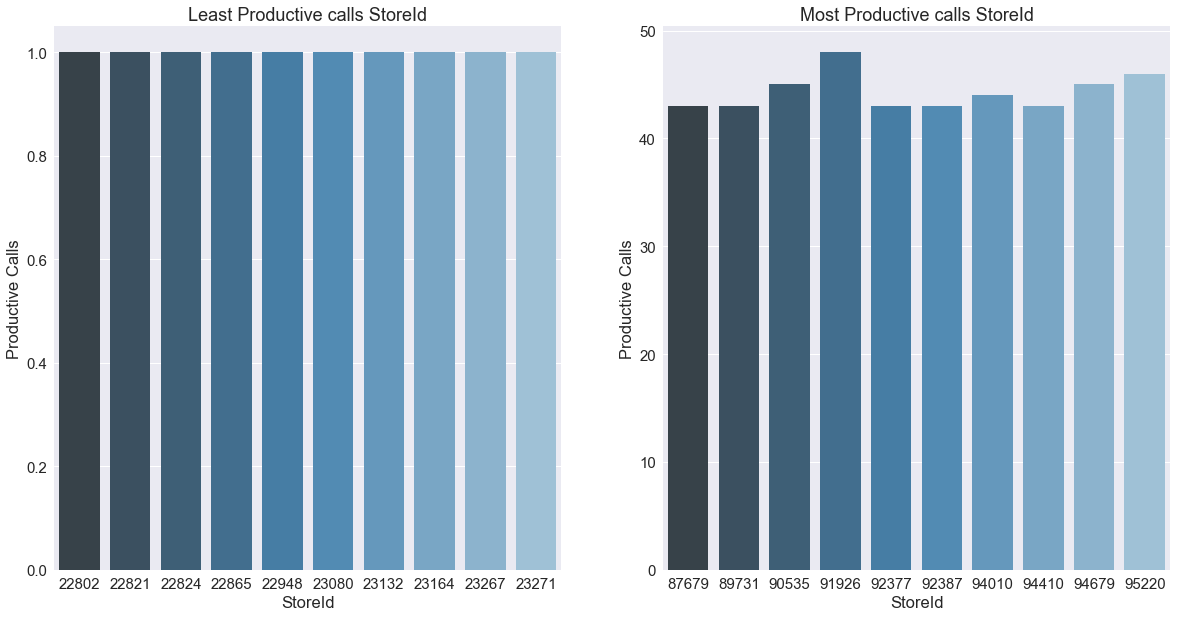

In [69]:
sns.set(font_scale=1.5)
render_grouped_productive(q3_2017,"StoreId","ProductiveCalls",1,'StoreId',"Productive Calls")

#Storeid with least 10 productive calls                          #StoreId with most 10 productive calls

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



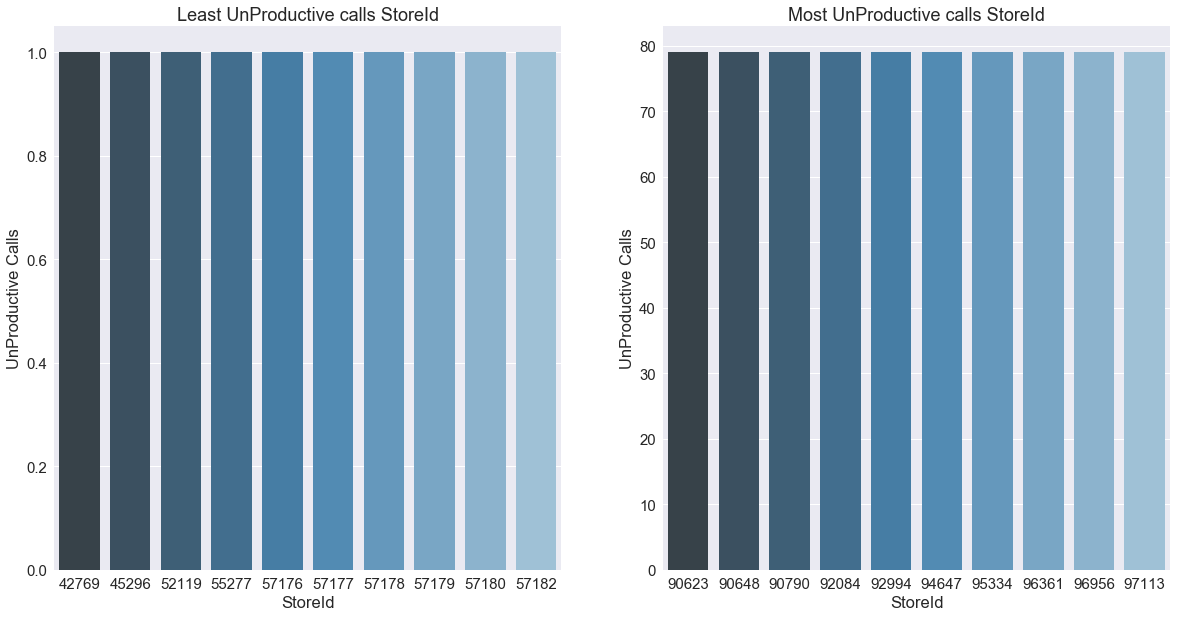

In [70]:
render_grouped_unproductive(q3_2017,"StoreId","ProductiveCalls",0,'StoreId',"UnProductive Calls")

#StoreId with least 10 unproductive calls                          #StoreId with most 10 unproductive calls

#### Q4 2017

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



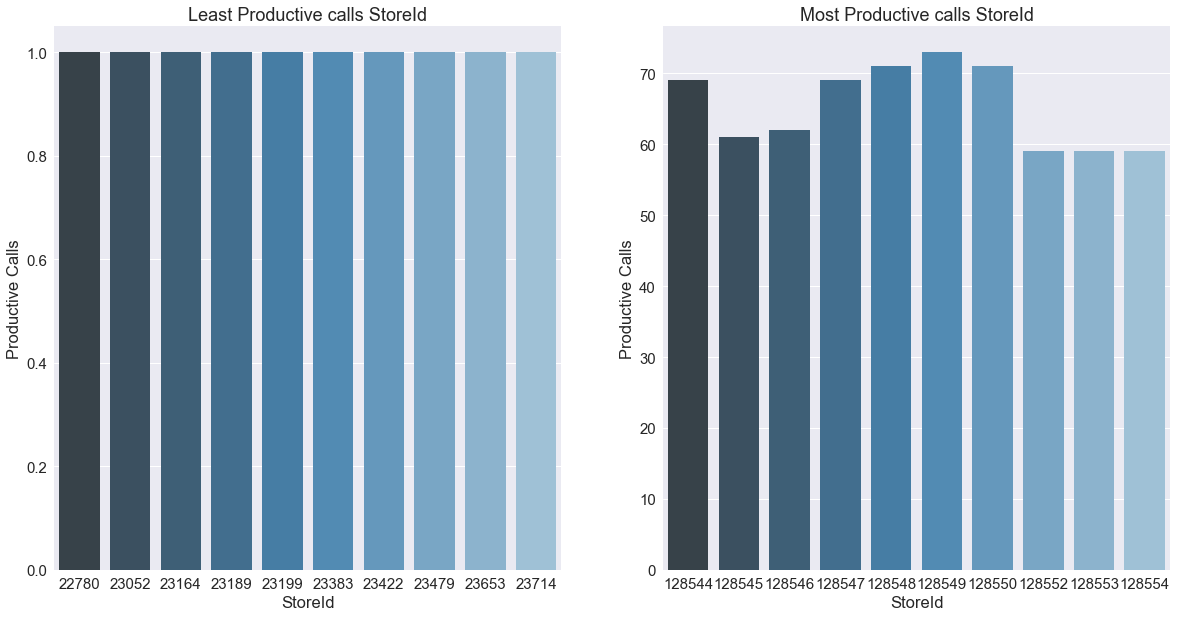

In [71]:
render_grouped_productive(q4_2017,"StoreId","ProductiveCalls",1,'StoreId',"Productive Calls")


/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



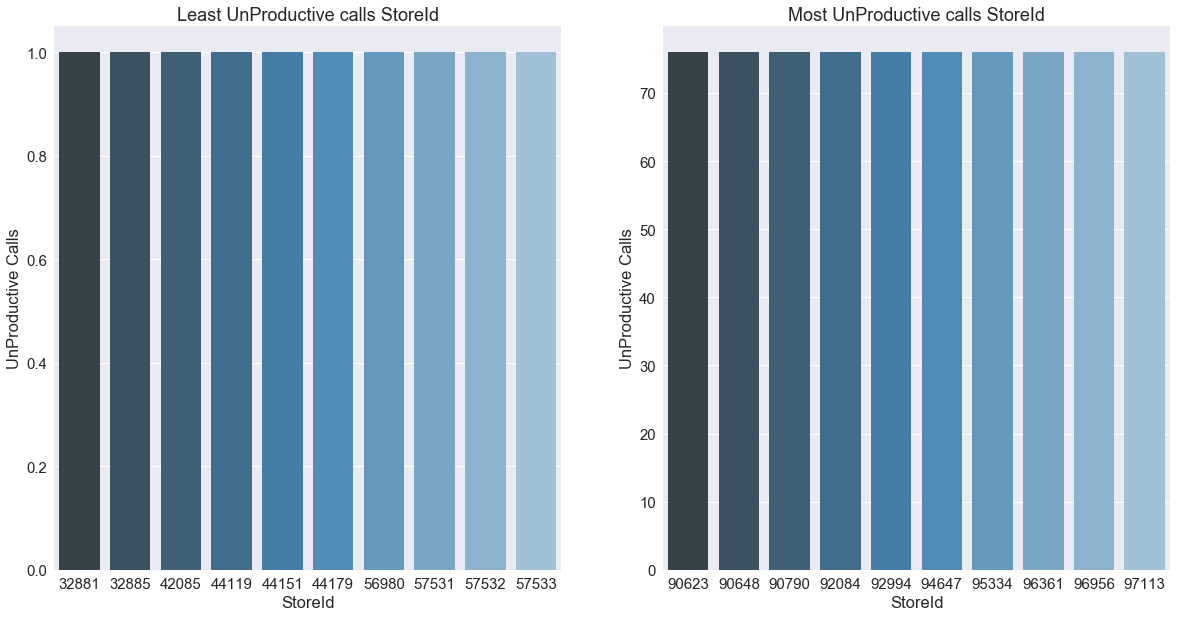

In [72]:
render_grouped_unproductive(q4_2017,"StoreId","ProductiveCalls",0,'StoreId',"UnProductive Calls")


## Correlations

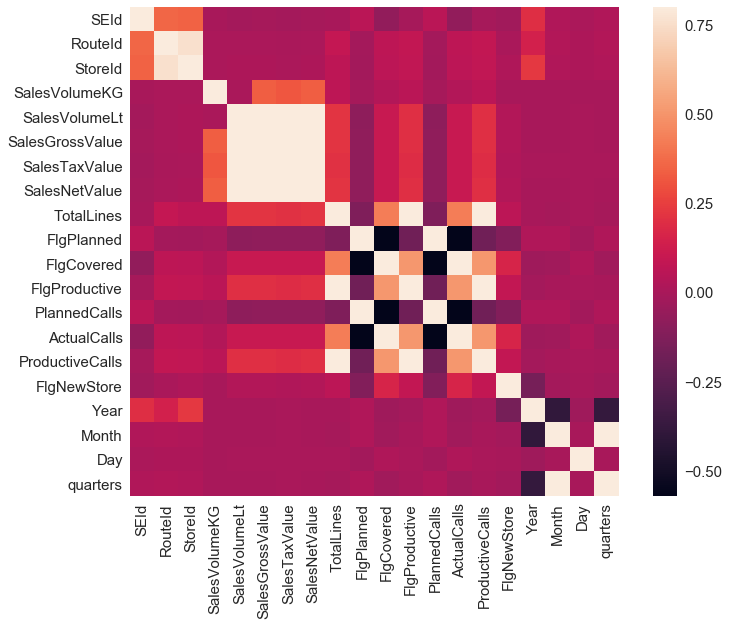

In [73]:
#correlation matrix
corrmat = data_file1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);



### The planning is so poor that there is negative correlation between planned calls and productive calls
### There is negative correlation between planned calls and actual calls too.

In [74]:
#Analysing total number of productive and unproductive stores
productive_call_list=list(data_file1.loc[data_file1["ProductiveCalls"]==1].StoreId.unique())
unproductive_call_list=list(data_file1.loc[data_file1["ProductiveCalls"]==0].StoreId.unique())
#stores that have never been productive over past 600 days.
unproductive_store_list=list(set(unproductive_call_list)-set(productive_call_list))
print("{} stores have never been productive over past 600 days!".format(len(unproductive_store_list)))

13549 stores have never been productive over past 600 days!


In [75]:
#number_of_unproductive_visits
number_of_unproductive_visits=data_file1.loc[data_file1["StoreId"].isin(unproductive_store_list)].shape[0]
print("To these {} unproductive stores there have been {} unproductive visits!".format(len(unproductive_store_list),number_of_unproductive_visits))


To these 13549 unproductive stores there have been 560081 unproductive visits!


#### One of the crucial things to remember is these are totally unproductive stores i.e. 0 productive visits ever.We are not even getting started on less productive stores!

### Following analysis shows the time that can be saved if these visits are eliminated

In [76]:
tota1_rep_hours_per_day=number_of_distinct_reps*8
tota1_rep_hours_per_day


1296

In [77]:
tota1_rep_hours=tota1_rep_hours_per_day*number_of_distinct_days
tota1_rep_hours

780192

In [78]:
total_number_of_visits=data_file1.shape[0]
total_number_of_visits

2514549

In [79]:
average_time_spent_in_a_store=total_number_of_visits/tota1_rep_hours
average_time_spent_in_a_store

3.2229874184816047

In [80]:
total_unproductive_time=average_time_spent_in_a_store*number_of_unproductive_visits/4
total_unproductive_time

451283.5040826489

In [81]:
time_saved_per_salesperson=total_unproductive_time/number_of_distinct_reps
time_saved_per_salesperson

2785.700642485487

In [82]:
percent_of_time_saved=(total_unproductive_time/tota1_rep_hours)*100
percent_of_time_saved

57.84262131406742

## Thus with this crude analysis if only all the unproductive stores are eliminated,it saves about 58% of the rep time.

## Lets look less productive stores.The best parameter for this would be avg. time between all visits vs avg. time between productive visits.

In [83]:
#some functions to analyse time diff between visits.
def create_store_v_dates_dict(dataframe):
    store_v_dates_dict={}
    unique_store_id=list(dataframe.StoreId.unique())
    #print(unique_store_id)
    for store_id in unique_store_id:
        modified_dataframe=dataframe.loc[dataframe["StoreId"]==store_id]
        visit_dates=list(modified_dataframe["Date"])
        store_v_dates_dict[store_id]=visit_dates
    
    return store_v_dates_dict
        
        
def create_time_diff_dict(store_v_dates_dict):
    
    time_diff_dict={}
    #print(store_v_dates_dict)
    for store_id,dates in store_v_dates_dict.items():
        diff=[]
        dates.sort()
        #print(dates)
        
        for i in range(len(dates)-1,0,-1):
            diff.append((dates[i]-dates[i-1]).days)
        
        time_diff_dict[store_id]=list(reversed(diff))
    return time_diff_dict
    
            
            

In [84]:
#getting data where productive calls ==1
productive_data=data_file1.loc[data_file1["ProductiveCalls"]==1]
productive_data.head()

,SEId,RouteId,StoreId,Date,SalesVolumeKG,SalesVolumeLt,SalesGrossValue,SalesTaxValue,SalesNetValue,TotalLines,...,FlgCovered,FlgProductive,PlannedCalls,ActualCalls,ProductiveCalls,FlgNewStore,Year,Month,Day,quarters
4,67,526,41378,2016-06-06,0.0,3.0,1146.3830,57.32,1203.7030,2,...,1,1,0,1,1,0,2016.0,6.0,6.0,2
13,239,1624,55009,2016-06-10,3.6,10.0,830.6220,18.18,848.8020,3,...,1,1,0,1,1,1,2016.0,6.0,10.0,2
14,58,1627,55052,2016-06-10,0.0,3.0,1263.1650,63.16,1326.3250,3,...,1,1,0,1,1,1,2016.0,6.0,10.0,2
21,52,299,33516,2016-06-10,0.0,0.5,223.0840,11.15,234.2340,1,...,1,1,0,1,1,0,2016.0,6.0,10.0,2
28,307,1568,53287,2016-06-11,0.9,0.0,86.5791,4.33,90.9091,1,...,1,1,0,1,1,0,2016.0,6.0,11.0,2


In [85]:
#getting necessary data structures to calculate average time differences
productive_store_v_dates_dict=create_store_v_dates_dict(productive_data)
productive_time_diff_dict=create_time_diff_dict(productive_store_v_dates_dict)
all_store_v_dates_dict=create_store_v_dates_dict(data_file1)
all_time_diff_dict=create_time_diff_dict(all_store_v_dates_dict)


In [86]:
#averaging the acquired data structure
time_avg_dict={}
all_list=[]
productive_list=[]
for store in productive_call_list:
    
    if len(productive_time_diff_dict[store])!=0:
        time_avg_dict[store]=[]
        time_avg_dict[store].append((sum(productive_time_diff_dict[store])/len(productive_time_diff_dict[store])))
        time_avg_dict[store].append((sum(all_time_diff_dict[store])/len(all_time_diff_dict[store])))
        all_list.append((sum(all_time_diff_dict[store])/len(all_time_diff_dict[store])))
        productive_list.append((sum(productive_time_diff_dict[store])/len(productive_time_diff_dict[store])))




/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



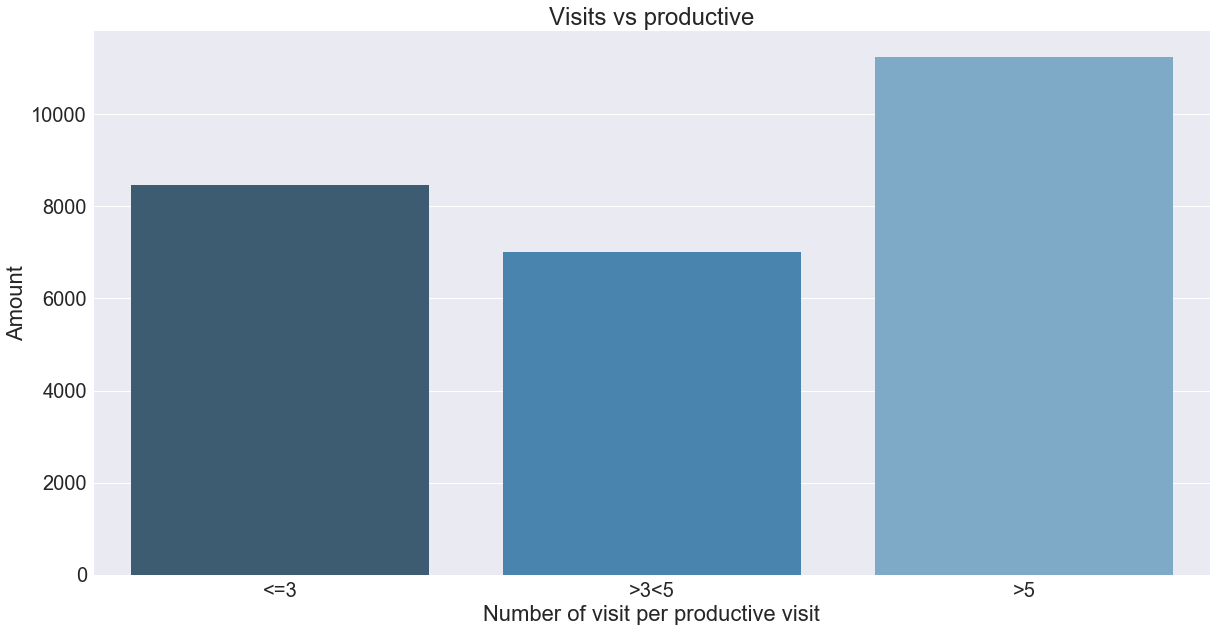

In [96]:
sns.set(font_scale=2)

factor_avg_dict={}
basket_1=[]
basket_2=[]
basket_3=[]
for key,value in time_avg_dict.items():
    net_val=value[0]/value[1]
    factor_avg_dict[key]=net_val
    if net_val <= 3:
        basket_1.append(net_val)
    if (net_val >3) and (net_val <= 5):
        basket_2.append(net_val)
    
    if net_val >5:
        basket_3.append(net_val)
        
        
        
#factor_avg_dict

plot_dict={"Number of visit per productive visit":["<=3",">3<5",">5"],"Amount":[len(basket_1),len(basket_2),len(basket_3)]}
fig, cnt =plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.barplot(x="Number of visit per productive visit", y="Amount", data=plot_dict, palette="Blues_d",ax=cnt)
ax.set(xlabel="Number of visit per productive visit", ylabel="Amount",title="Visits vs productive")
fig.show()
#plot_bar_plotly("Visits vs productive","Range of number of visits per productive visit","Number of stores",["<=3",">3<5",">5"],[len(basket_1),len(basket_2),len(basket_3)])

### Huge differences between the avg time of all visits to a store and avg time of productive visit to a store indicates  that many stores are visited weekly or biweekly but they place orders once in a quarter etc.Urges requirement of an optimized beat plan

### To find this optimized plan we will take help of state of the art predictive techniques.

# Predictive Analysis

In [88]:
#Reading the second csv
dateparse=lambda x:pd.datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
data_file2=pd.read_csv("../dataset/file2.csv",sep="|",parse_dates=["Date"],date_parser=dateparse)
data_file2.head()

,RouteId,StoreId,Date,OrderID,OrderDetailID,ProductID,UOM,OrderQty,Order Volume KG/LTR,OrderValBeforeTax,TaxValue,OrderValAfterTax
0,261,36732,2016-05-23,8361,19796,13,Lt,5,1.0,429.000,21.45,450.450
1,261,36717,2016-05-23,8365,19802,20,Lt,2,1.0,388.007,19.40,407.407
2,261,36732,2016-05-30,13160,31290,4,Lt,10,1.0,446.158,22.31,468.468
3,261,33175,2016-06-27,30735,67105,4,Lt,10,1.0,446.158,22.31,468.468
4,261,38600,2016-07-04,34760,74518,13,Lt,5,1.0,429.000,21.45,450.450


In [89]:
#Adding day,date and year features
data_file2["Year"]=data_file2["Date"].dt.year
data_file2['Year'] = data_file2['Year'].astype(float)
data_file2["Month"]=data_file2["Date"].dt.month
data_file2['Month'] = data_file2['Month'].astype(float)
data_file2["Day"]=data_file2["Date"].dt.day
data_file2['Day'] = data_file2['Day'].astype(float)
data_file2.head()

,RouteId,StoreId,Date,OrderID,OrderDetailID,ProductID,UOM,OrderQty,Order Volume KG/LTR,OrderValBeforeTax,TaxValue,OrderValAfterTax,Year,Month,Day
0,261,36732,2016-05-23,8361,19796,13,Lt,5,1.0,429.000,21.45,450.450,2016.0,5.0,23.0
1,261,36717,2016-05-23,8365,19802,20,Lt,2,1.0,388.007,19.40,407.407,2016.0,5.0,23.0
2,261,36732,2016-05-30,13160,31290,4,Lt,10,1.0,446.158,22.31,468.468,2016.0,5.0,30.0
3,261,33175,2016-06-27,30735,67105,4,Lt,10,1.0,446.158,22.31,468.468,2016.0,6.0,27.0
4,261,38600,2016-07-04,34760,74518,13,Lt,5,1.0,429.000,21.45,450.450,2016.0,7.0,4.0


In [90]:
#finding unique stores
#store_id=list(data_file2.StoreId.unique())
store_jan_once=list(data_file2.loc[data_file2["Month"]==1]["StoreId"].value_counts()[-3250:].index)


### In order to predict when a store needs to be visited in January 2018,we use the historical data of orders to figure out when to visit a less productive store.

In [91]:
#Writing the model
op_dict={}
X_test=pd.DataFrame({"month":[1],"year":[2018]})
for i in tqdm(range(len(store_jan_once))):
    data_store=data_file2.loc[data_file2["StoreId"]==store_jan_once[i]]
    #data_store_month=data_store.loc[data_store["Month"]==1]
    #data_store_month
    dates=pd.DatetimeIndex(data_store["Date"].unique()).sort_values()
    df=pd.DataFrame()
    df["day"]=dates.day
    df["month"]=dates.month
    df["year"]=dates.year
    X_train=df[["month","year"]]
    y_train=df["day"]
    gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, y_train)
    predictions = gbm.predict(X_test)
    op_dict[store_jan_once[i]]=predictions[0]
    

100%|██████████| 3250/3250 [02:39<00:00, 20.38it/s]


In [92]:
store_jan_once=list(data_file2.loc[data_file2["Month"]==1]["StoreId"].value_counts()[-3200:].index)
week_listing={}
b_1=[]
b_2=[]
b_3=[]
b_4=[]

for key,value in op_dict.items():
    if key in store_jan_once:
        if value <=7:
            b_1.append(value)
            week_listing[key]=1
        if value >7 and value <= 14:
            b_2.append(value)
            week_listing[key]=2
        if value >14 and value <= 21:
            b_3.append(value)
            week_listing[key]=3
        if value >21:
            b_4.append(value)
            week_listing[key]=4

/Users/jasdeep/PycharmProjects/predictive_standalone/pred_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



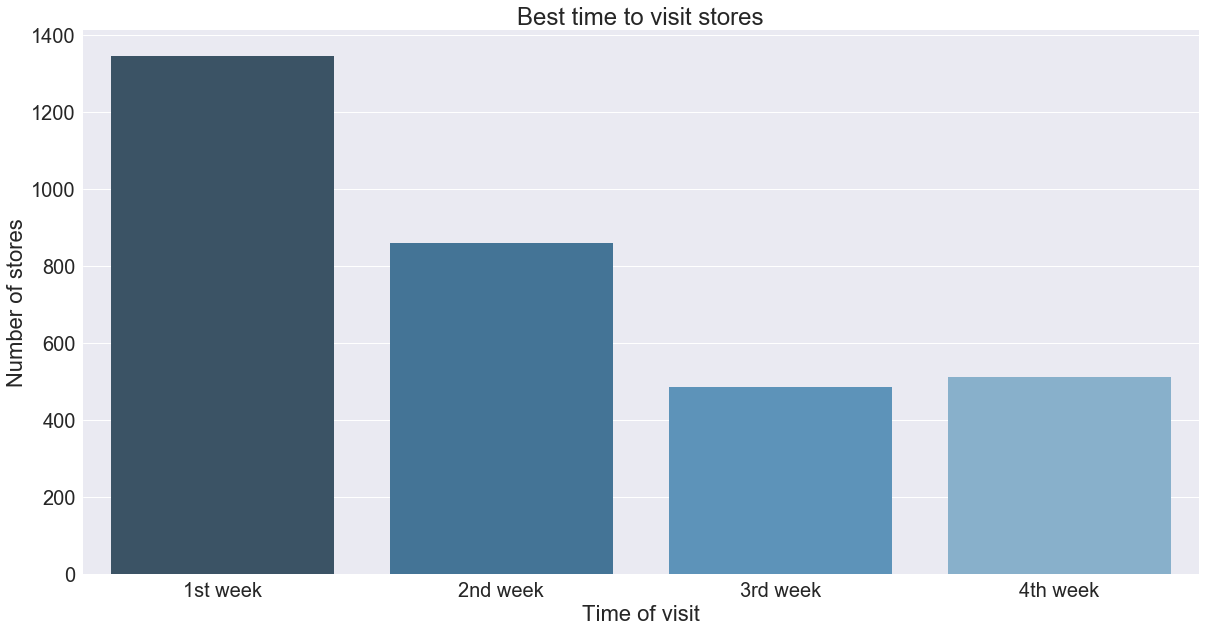

In [97]:
plot_dict={"Time of visit":["1st week","2nd week","3rd week","4th week"],"Number of stores":[len(b_1),len(b_2),len(b_3),len(b_4)]}
fig, cnt =plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = sns.barplot(x="Time of visit", y="Number of stores", data=plot_dict, palette="Blues_d",ax=cnt)
ax.set(xlabel="Time of visit", ylabel="Number of stores",title="Best time to visit stores")
fig.show()
#plot_bar_plotly("Best time to visit stores","Week of visit","Number of stores",["1st week","2nd week","3rd week","4th week"],[len(b_1),len(b_2),len(b_3),len(b_4)])

In [94]:

#all visits january
all_jan_data=data_file1.loc[data_file1["Month"]==1]
#all visits january to stores giving productive order once
data_jan_once=all_jan_data.loc[all_jan_data["StoreId"].isin(store_jan_once)]

print("There are {} stores that gave the order once in January.They were visited {} times to get those orders.Now they will be visited {} times.".format(len(store_jan_once),data_jan_once.shape[0],len(store_jan_once)))


There are 3200 stores that gave the order once in January.They were visited 11938 times to get those orders.Now they will be visited 3200 times.


# Image based tracking

## Two biggest problem that sales team faces on the retailer side is tracking of inventory of a particular store so that it can be restored on time to avoid returning empty handed costumers due to negligence of store owner.Image based tracking can solve this problem-

### The image based tracking can be used in two forms:

### Inventory tracking- Capturing shelves of store to study left inventory using state of the art image segmentation techniques

### Sales tracking- Capturing the items sold at the time of sale to keep a track of sales thus keeping an eye on inventory.

### Both the methods if used simultaneously would concrete inventory tracking and schedule better supplies.

# AI can be also leveraged in FMCG sector as...

### Pricing - Optimize per time period, per item, per store

### Location of new stores

### Product layout in stores- Where to keep what

### Merchandizing - when to start stocking & discontinuing product lines

### Shrinkage analytics - Theft detection

### Warranty Analytics

### Cannibalization Analysis

### Next best offer analytics

